In [1]:
# First, do the following

# scripts/generate_reactions
# scripts/build_reactions database/reactions/eclogite_slb_rx.rxml

In [2]:
import os,sys
import pandas as pd
import numpy as np
import sympy as sym
import time
import re
import types
import ast
import sys
sym.init_printing()
sys.path.append(os.path.join(os.path.pardir, 'python'))

from tcg_slb.reactions import SLBReactions

#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

In [3]:
dbfile = os.path.abspath(os.path.join(os.path.pardir, 'database', 'tcg_slb_database.tar.gz'))
dbpath = "file://{}".format(dbfile)
dbpath

'file:///workspaces/tcg-ec/systems/ec/database/tcg_slb_database.tar.gz'

In [4]:
reference= 'ec_reactions' 

Overriding T0 -- already exists in model_dict
Overriding R -- already exists in model_dict
Overriding T0 -- already exists in model_dict
Overriding R -- already exists in model_dict


[('T0', 'K', T0), ('R', 'J/mol/K', R)]

{'name': 'ec_slb_all_rn',
 'reference': 'ec_reactions',
 'T0': 2000.0,
 'R': 8.31446261815324}

In [5]:
import sys, os
import numpy as np

sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.scipy import ScipyPDReactiveODE
from tcg_slb.phasediagram.base import PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *


scipy available


In [6]:
pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'ec1_slb_rx', 'lib', 'python'+pv, 'site-packages/')) # the final slash is necessary!
import py_ec1_slb_rx as tcgdb1
rxn1 = tcgdb1.ec1_slb_rx()
rxn1.report()

Reaction object: ec1_slb_rx

Phase 0 Clinopyroxene_slb_ph (cpx)
     Endmember 0 Diopside_slb_em : CaMgSi2O6_(cpx)
     Endmember 1 Hedenbergite_slb_em : CaFeSi2O6_(cpx)
     Endmember 2 Clinoenstatite_slb_em : Mg2Si2O6_(cpx)
     Endmember 3 CaTschermaks_slb_em : CaAl2SiO6_(cpx)
     Endmember 4 Jadeite_slb_em : NaAlSi2O6_(cpx)
Phase 1 Orthopyroxene_slb_ph (opx)
     Endmember 0 Enstatite_slb_em : Mg2Si2O6_(opx)
     Endmember 1 Ferrosilite_slb_em : Fe2Si2O6_(opx)
     Endmember 2 MgTschermaks_slb_em : MgAl2SiO6_(opx)
     Endmember 3 OrthoDiopside_slb_em : CaMgSi2O6_(opx)
Phase 2 Garnet_slb_ph (gt)
     Endmember 0 Pyrope_slb_em : Mg3Al2Si3O12_(gt)
     Endmember 1 Almandine_slb_em : Fe3Al2Si3O12_(gt)
     Endmember 2 Grossular_slb_em : Ca3Al2Si3O12_(gt)
     Endmember 3 MgMajorite_slb_em : Mg4Si4O12_(gt)
     Endmember 4 NaMajorite_slb_em : Na2Al2Si4O12_(gt)
Phase 3 Feldspar_slb_ph (plg)
     Endmember 0 Anorthite_slb_em : CaAl2Si2O8_(plg)
     Endmember 1 Albite_slb_em : NaAlSi3O8_

In [7]:
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'ec2_slb_rx', 'lib', 'python'+pv, 'site-packages/')) # the final slash is necessary!
import py_ec2_slb_rx as tcgdb2
rxn2 = tcgdb2.ec2_slb_rx()
rxn2.report()

Reaction object: ec2_slb_rx

Phase 0 Clinopyroxene_slb_ph (cpx)
     Endmember 0 Diopside_slb_em : CaMgSi2O6_(cpx)
     Endmember 1 Hedenbergite_slb_em : CaFeSi2O6_(cpx)
     Endmember 2 Clinoenstatite_slb_em : Mg2Si2O6_(cpx)
     Endmember 3 CaTschermaks_slb_em : CaAl2SiO6_(cpx)
     Endmember 4 Jadeite_slb_em : NaAlSi2O6_(cpx)
Phase 1 Orthopyroxene_slb_ph (opx)
     Endmember 0 Enstatite_slb_em : Mg2Si2O6_(opx)
     Endmember 1 Ferrosilite_slb_em : Fe2Si2O6_(opx)
     Endmember 2 MgTschermaks_slb_em : MgAl2SiO6_(opx)
     Endmember 3 OrthoDiopside_slb_em : CaMgSi2O6_(opx)
Phase 2 Garnet_slb_ph (gt)
     Endmember 0 Pyrope_slb_em : Mg3Al2Si3O12_(gt)
     Endmember 1 Almandine_slb_em : Fe3Al2Si3O12_(gt)
     Endmember 2 Grossular_slb_em : Ca3Al2Si3O12_(gt)
     Endmember 3 MgMajorite_slb_em : Mg4Si4O12_(gt)
     Endmember 4 NaMajorite_slb_em : Na2Al2Si4O12_(gt)
Phase 3 Feldspar_slb_ph (plg)
     Endmember 0 Anorthite_slb_em : CaAl2Si2O8_(plg)
     Endmember 1 Albite_slb_em : NaAlSi3O8_

In [8]:
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'ec3_slb_rx', 'lib', 'python'+pv, 'site-packages/')) # the final slash is necessary!
import py_ec3_slb_rx as tcgdb3
rxn3 = tcgdb3.ec3_slb_rx()
rxn3.report()

Reaction object: ec3_slb_rx

Phase 0 Clinopyroxene_slb_ph (cpx)
     Endmember 0 Diopside_slb_em : CaMgSi2O6_(cpx)
     Endmember 1 Hedenbergite_slb_em : CaFeSi2O6_(cpx)
     Endmember 2 Clinoenstatite_slb_em : Mg2Si2O6_(cpx)
     Endmember 3 CaTschermaks_slb_em : CaAl2SiO6_(cpx)
     Endmember 4 Jadeite_slb_em : NaAlSi2O6_(cpx)
Phase 1 Orthopyroxene_slb_ph (opx)
     Endmember 0 Enstatite_slb_em : Mg2Si2O6_(opx)
     Endmember 1 Ferrosilite_slb_em : Fe2Si2O6_(opx)
     Endmember 2 MgTschermaks_slb_em : MgAl2SiO6_(opx)
     Endmember 3 OrthoDiopside_slb_em : CaMgSi2O6_(opx)
Phase 2 Garnet_slb_ph (gt)
     Endmember 0 Pyrope_slb_em : Mg3Al2Si3O12_(gt)
     Endmember 1 Almandine_slb_em : Fe3Al2Si3O12_(gt)
     Endmember 2 Grossular_slb_em : Ca3Al2Si3O12_(gt)
     Endmember 3 MgMajorite_slb_em : Mg4Si4O12_(gt)
     Endmember 4 NaMajorite_slb_em : Na2Al2Si4O12_(gt)
Phase 3 Feldspar_slb_ph (plg)
     Endmember 0 Anorthite_slb_em : CaAl2Si2O8_(plg)
     Endmember 1 Albite_slb_em : NaAlSi3O8_

array([0.2  , 0.15 , 0.35 , 0.285, 0.015])

array([0.25, 0.  , 0.  , 0.  , 0.75, 0.5 , 0.5 , 0.  , 0.  , 0.4 , 0.3 ,
       0.3 , 0.  , 0.  , 0.25, 0.75, 1.  ])

(array(['Clinopyroxene_slb_ph', 'Orthopyroxene_slb_ph', 'Garnet_slb_ph',
        'Feldspar_slb_ph'], dtype='<U20'),
 array(['cpx', 'opx', 'gt', 'plg'], dtype='<U3'))

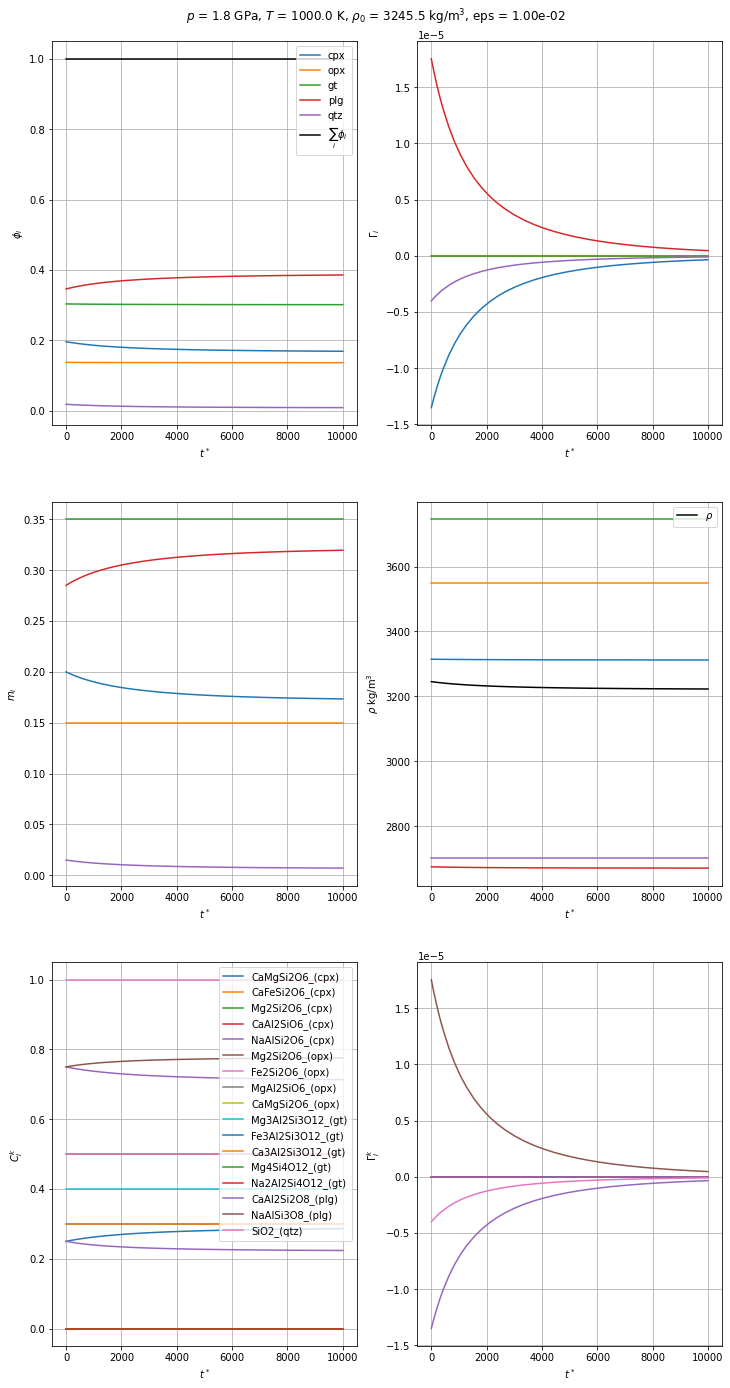

array([0.2  , 0.15 , 0.35 , 0.285, 0.015])

array([0.25, 0.  , 0.  , 0.  , 0.75, 0.5 , 0.5 , 0.  , 0.  , 0.4 , 0.3 ,
       0.3 , 0.  , 0.  , 0.25, 0.75, 1.  ])

(array(['Clinopyroxene_slb_ph', 'Orthopyroxene_slb_ph', 'Garnet_slb_ph',
        'Feldspar_slb_ph', 'Quartz_slb_ph'], dtype='<U20'),
 array(['cpx', 'opx', 'gt', 'plg', 'qtz'], dtype='<U3'))

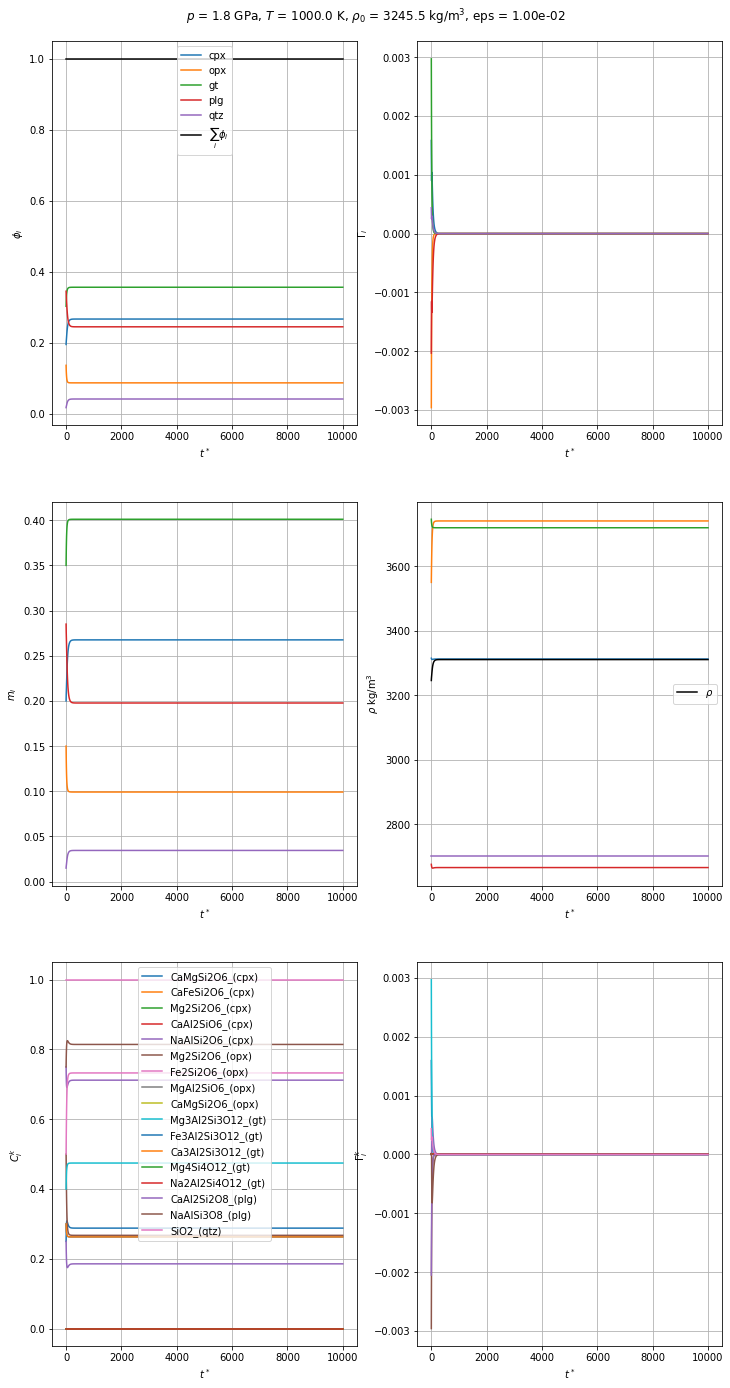

array([0.2  , 0.15 , 0.35 , 0.285, 0.015])

array([0.25, 0.  , 0.  , 0.  , 0.75, 0.5 , 0.5 , 0.  , 0.  , 0.4 , 0.3 ,
       0.3 , 0.  , 0.  , 0.25, 0.75, 1.  ])

(array(['Clinopyroxene_slb_ph', 'Orthopyroxene_slb_ph', 'Garnet_slb_ph',
        'Quartz_slb_ph'], dtype='<U20'),
 array(['cpx', 'opx', 'gt', 'qtz'], dtype='<U3'))

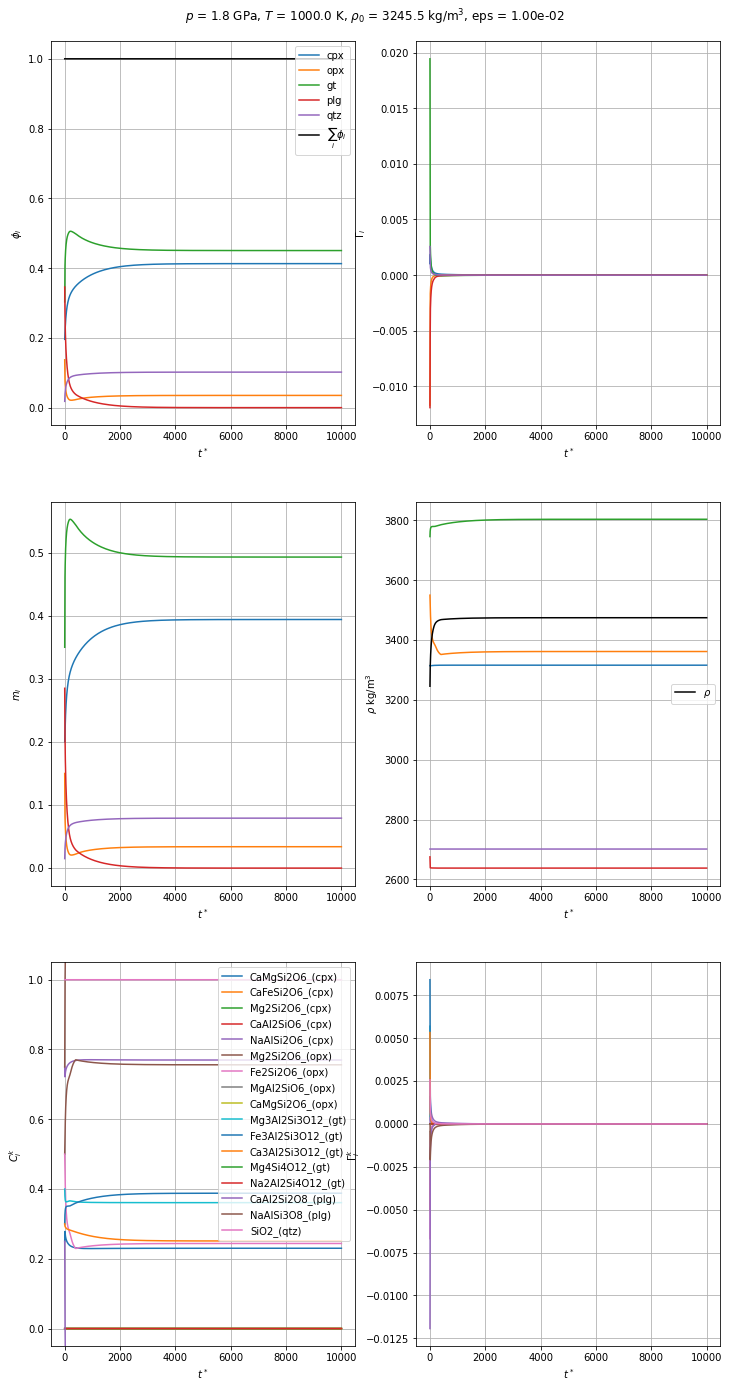

In [14]:
for i, rxn in enumerate([rxn1, rxn2, rxn3]):
    
        #             cpx    opx   gt  fld   qtz
    mi0 = np.asarray([0.2, 0.15, 0.35, 0.285, 0.015]) # initial phase comps
    Cik0 = np.asarray([
        0.25, 0.0, 0.0, 0.0, 0.75, # di, hed, clinoenstatite, Ca, jd
        0.5, 0.5, 0.0, 0.0,        # en, fsl, Mg, OrthoDi
        0.4, 0.3, 0.3, 0.0, 0.0,   # py, al, gs, Mg, Na
        0.25, 0.75,                # An, Ab
        1.,                        # qtz
    ])

    '''
    Cik0 = np.zeros(ode.K) # initial endmember comps
    for i in range(ode.I):
        j1 = sum(ode.Kis[:i])
        j2 = sum(ode.Kis[:i+1])
        nEndmembers = ode.Kis[i]
        if nEndmembers == 1:
            Cik0[j1:j2] = 1.
        else:
            if i==4:
                #                                       pyr  alm  grs  mg-  na0
                Cik0[j1:j2][:nEndmembers] = np.asarray([0.4, 0.3, 0.1, 0.2, 0.0])
            elif i==5:
                Cik0[j1:j2][:nEndmembers] = np.ones(nEndmembers)/nEndmembers
    '''       
    display(mi0)
    display(Cik0)

    # initial temperature, pressure and phase volume fraction
    Ti = 1000.0 # Kelvin
    pi = GPa2Bar(1.8) # bars

    ode = ScipyPDReactiveODE(rxn)
    ode.solve(Ti,pi,mi0,Cik0,10000.0) # T, p, mi0, Cik0, t_end, **kwargs
    display(ode.stime)
    display(ode.final_phases(1.e-2))
    ode.plot()


In [15]:
import pickle
from pathlib import Path

get_pickle_path = lambda rxnObj : Path('output', rxnObj.name() + '.pickle')

def load_grid(reactionObject):
    filename = get_pickle_path(reactionObject)
    with open(filename, 'rb') as pfile:
        bdfgrid = pickle.load(pfile)
    return bdfgrid

def save_grid(bdfgrid, reactionObject):
    filename = get_pickle_path(reactionObject)
    filename.parent.mkdir(exist_ok=True, parents=True)
    with open(filename, 'wb+') as pfile:
        pickle.dump(bdfgrid, pfile)

def solve_reaction_grid(reactionObject, p_range, T_range, filename=None, reload=False, save=False, odeClass=ScipyPDReactiveODE, Cik0=Cik0, mi0=mi0):
    if reload:
        load_grid(reactionObject)

    i0 = 2 # doesn't matter as long as you pass cik0
    end = 1e5 # end time

    bdfgrid = PDReactiveGrid()

    bdfgrid.solve(reactionObject, odeClass, i0, ['p', 'T'], p_range, T_range, end, Cik0=Cik0, mi0=mi0)

    if save:
        save_grid(bdfgrid, reactionObject)

    return bdfgrid

def plot_grid(bdfgrid, p_range=np.linspace(0.5,2.5,10), T_range=np.linspace(500,1000,10), plot_phases=True):
    import matplotlib.pyplot as plt

    def decorate(pdrgd):
        def new_setup_axes(self,axi):
            axi.axis('off')
            ax = axi.inset_axes([-0.001,-0.005,0.998,0.993])
            ax.patch.set_alpha(0.0)
            #ax.set_xlim([min(p_range), max(p_range)])
            ax.set_xlabel("Pressure (GPa)")

            #ax.set_ylim([min(T_range), max(T_range)])
            ax.set_ylabel("Temperature (K)")

            return ax
        
        #replace the display with newdisplay
        pdrgd.setup_axes = new_setup_axes
        
        #return the modified student 
        return pdrgd

    bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid) 
    s=bdfdiag.plot_rho()
    s.set_cmap('viridis')

    if plot_phases:
        bdfdiag.plot_phases()

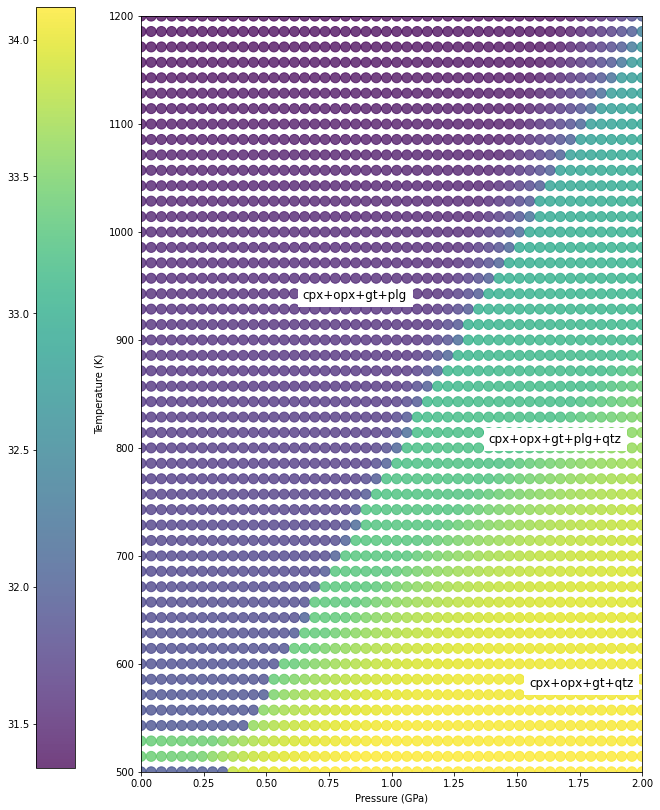

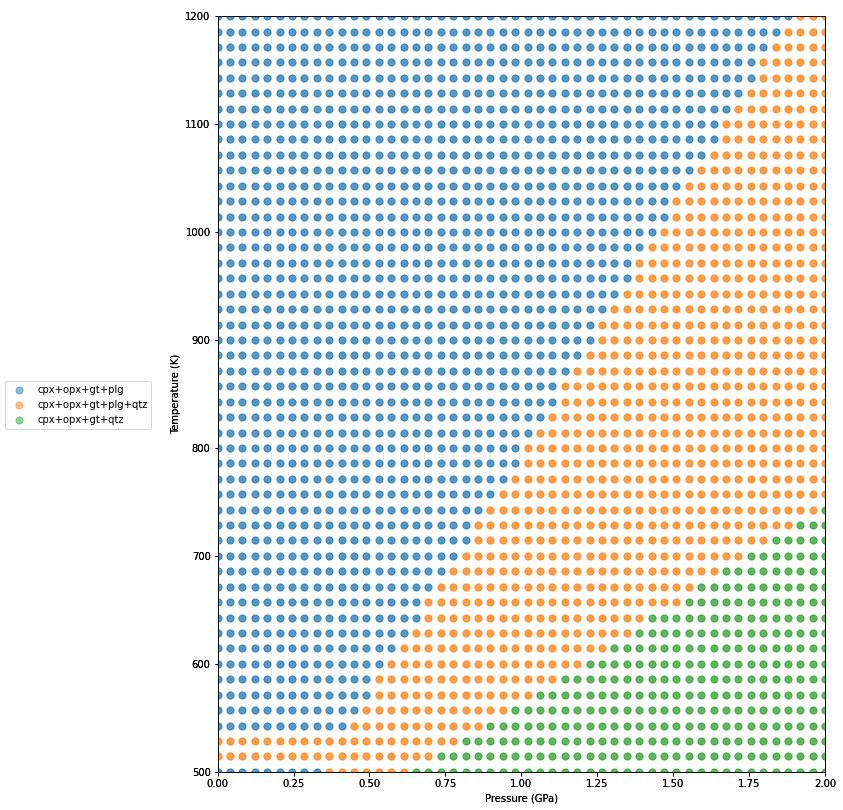

In [67]:
p_range = np.linspace(0.5, 2.5, 50)
T_range = np.linspace(500.0, 1200.0, 50)
grid1 = solve_reaction_grid(rxn1, p_range, T_range, reload=False, save=True)
plot_grid(grid1, p_range,T_range )

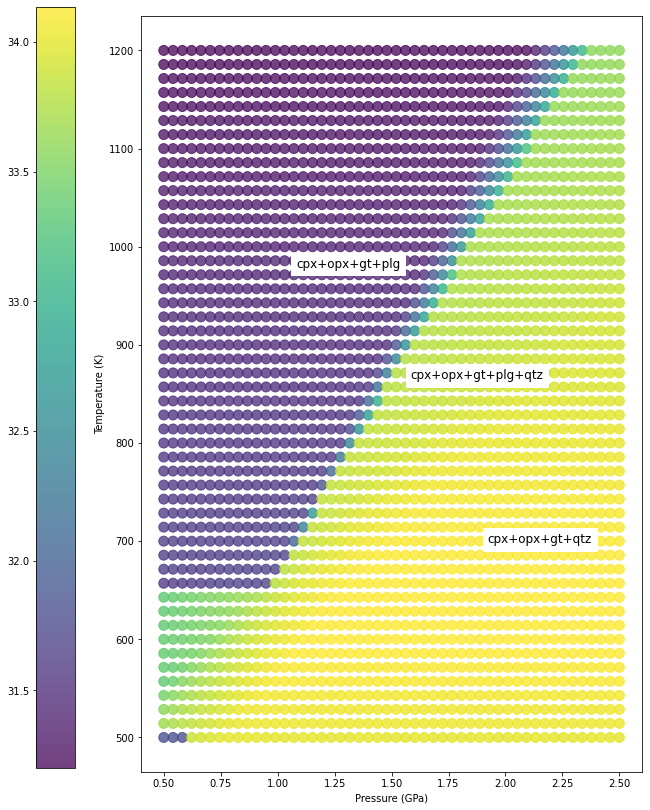

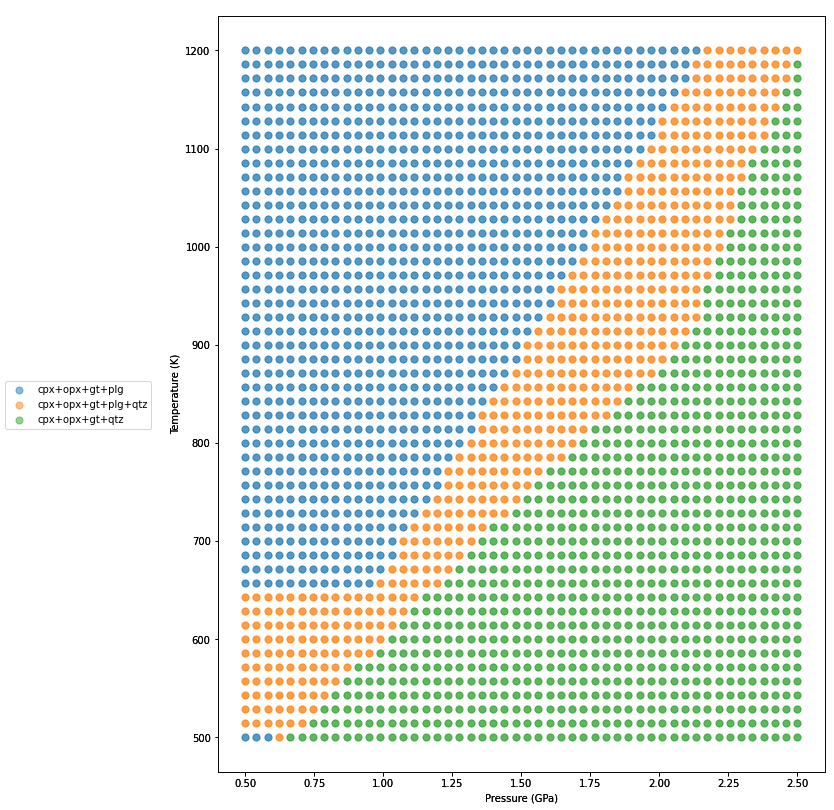

In [27]:
p_range = np.linspace(0.5, 2.5, 50)
T_range = np.linspace(500.0, 1200.0, 50)

grid2 = solve_reaction_grid(rxn2, p_range, T_range, reload=False, save=False)
plot_grid(grid2,p_range,T_range)


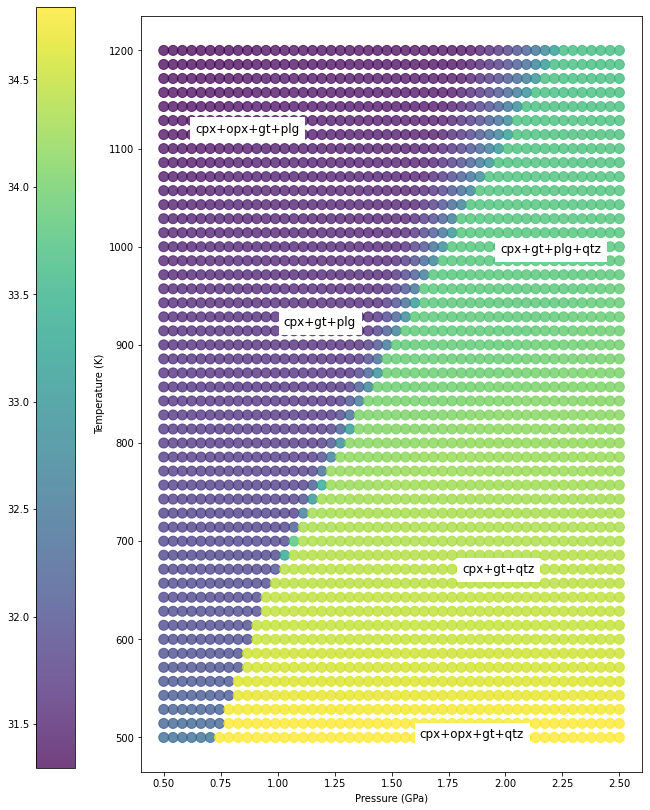

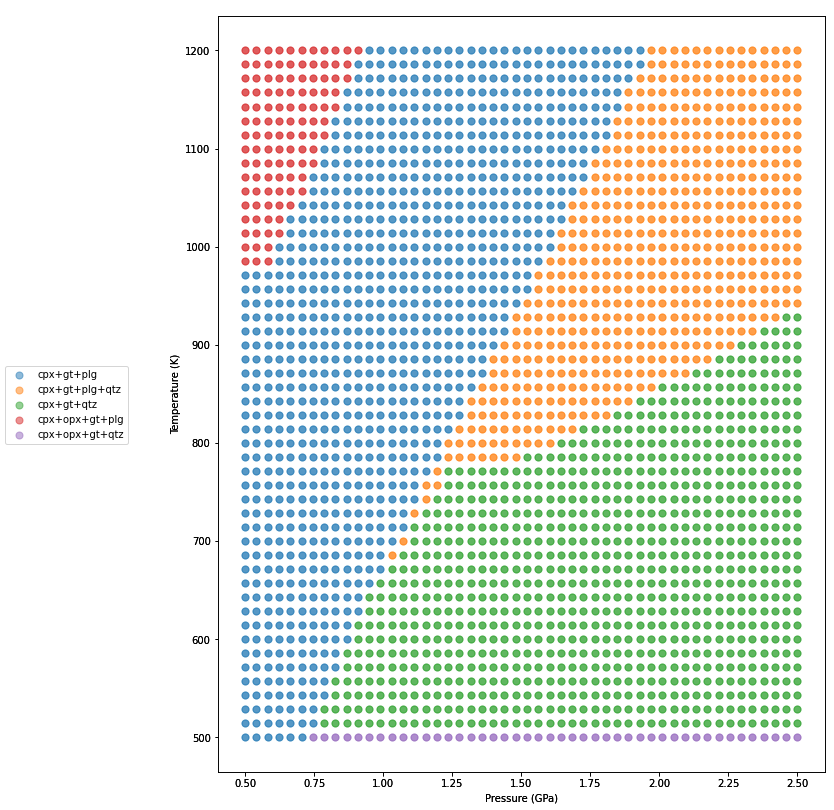

In [26]:
p_range = np.linspace(0.5, 2.5, 50)
T_range = np.linspace(500.0, 1200.0, 50)

grid3 = solve_reaction_grid(rxn3, p_range, T_range, reload=False, save=True)
plot_grid(grid3, p_range, T_range)